# OUTDATED, the examples moved to the manual
## See https://empymod.readthedocs.io/en/stable/examples

----

# Time-domain examples: step and impulse responses

These examples compare the analytical solution with `empymod` for time-domain step and impulse responses for inline, x-directed source and receivers, for the four different frequency-to-time methods **QWE**, **FHT**, **FFTLog**, and **FFT**. Which method is faster and which is more precise depends on the model (land or marine, source/receiver at air-interface or not) and the response (step or impulse).

In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.constants import mu_0       # Permeability of free space  [H/m]

import empymod as epm

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100
colors = [color['color'] for color in list(plt.rcParams['axes.prop_cycle'])]

## Analytical solutions for source and receiver at the interface between two half-spaces

The time-domain step and impulse responses for a source at the origin ($x_s = y_s = z_s = 0\,$m) and an in-line receiver at the surface ($y_r = z_r = 0\,$m), is given by the following equations, where $\rho_h$ is horizontal resistivity ($\Omega\,$m), $\lambda$ is anisotropy (-), with $\lambda = \sqrt{\rho_v/\rho_h}$, $r$ is offset (m), $t$ is time (s), and
$\tau_h = \sqrt{\mu_0 r^2/(\rho_h t)}$; $\mu_0$ is the magnetic permeability of free space (H/m).


### Time Domain: Step Response $\mathbf{\mathcal{H}(t)}$

$$
    E_x(\rho_h,\lambda,r,t) = \frac{\rho_h}{2 \pi r^3} \left[ 2\lambda +
    \rm{erf}\left(\frac{\tau_h}{2}\right) - 2\lambda
    \rm{erf}\left(\frac{\tau_h}{2\lambda}\right) + \frac{\tau_h}{\sqrt{\pi}}
    \exp\left(- \frac{\tau_h^2}{4\lambda^2}\right)   \right]
$$

### Time Domain: Impulse Response $\mathbf{\delta(t)}$

$$
    \dot{E}_x(\rho_h,\lambda,r,t) = \frac{\rho_h}{2 \pi r^3} \left[ \delta(t) +
    \frac{\tau_h}{2t\sqrt{\pi}} \left\{ - \exp\left(-\frac{\tau_h^2}{4}\right) +
    \left( \frac{\tau_h^2}{2 \lambda^2} + 1 \right) \exp\left(-
    \frac{\tau_h^2}{4 \lambda^2}\right) \right\} \right]
$$



### Reference
Equations 3.2 and 3.3 in Werthmüller, D., 2009, Inversion of multi-transient EM data from anisotropic media: M.S. thesis, TU Delft, ETH Zürich, RWTH Aachen; http://repository.tudelft.nl/islandora/object/uuid:f4b071c1-8e55-4ec5-86c6-a2d54c3eda5a.

### Analytical functions

In [3]:
def ee_xx_impulse(res, aniso, off, time):
    """VTI-Halfspace impulse response, xx, inline.

    res   : horizontal resistivity [Ohm.m]
    aniso : anisotropy [-]
    off   : offset [m]
    time  : time(s) [s]
    """
    tau_h = np.sqrt(mu_0*off**2/(res*time))
    t0 = tau_h/(2*time*np.sqrt(np.pi))
    t1 = np.exp(-tau_h**2/4)
    t2 = tau_h**2/(2*aniso**2) + 1
    t3 = np.exp(-tau_h**2/(4*aniso**2))
    Exx = res/(2*np.pi*off**3)*t0*(-t1 + t2*t3)
    Exx[time == 0] = res/(2*np.pi*off**3)  # Delta dirac part
    return Exx

def ee_xx_step(res, aniso, off, time):
    """VTI-Halfspace step response, xx, inline.

    res   : horizontal resistivity [Ohm.m]
    aniso : anisotropy [-]
    off   : offset [m]
    time  : time(s) [s]
    """
    tau_h = np.sqrt(mu_0*off**2/(res*time))
    t0 = erf(tau_h/2)
    t1 = 2*aniso*erf(tau_h/(2*aniso))
    t2 = tau_h/np.sqrt(np.pi)*np.exp(-tau_h**2/(4*aniso**2))
    Exx = res/(2*np.pi*off**3)*(2*aniso + t0 - t1 + t2)
    return Exx

## Example 1: Source and receiver at z=0m

Comparison with analytical solution; put 1 mm below the interface, as they would be regarded as in the air by `emmod` otherwise.

In [4]:
src = [0, 0, 0.001]          # Source at origin, slightly below interface
rec = [6000, 0, 0.001]       # Receivers in-line, 0.5m below interface
res = [2e14, 10]             # Resistivity: [air, half-space]
aniso = [1, 2]               # Anisotropy: [air, half-space]
eperm = [0, 1]               # Set el. permittivity of air to 0 because of numerical noise
t = np.logspace(-2, 1, 301)  # Desired times (s)

# Collect parameters
inparg = {'src': src, 'rec': rec, 'depth': 0, 'freqtime': t, 'res': res, 'aniso': aniso,
          'epermH': eperm, 'epermV': eperm, 'ht': 'fht', 'verb': 2}

### Impulse response

In [5]:
ex = ee_xx_impulse(res[1], aniso[1], rec[0], t)

inparg['signal'] = 0 # signal 0 = impulse
print('QWE')
qwe = epm.dipole(**inparg, ft='qwe')
print('FHT (Sine)')
sin = epm.dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
ftl = epm.dipole(**inparg, ft='fftlog')
print('FFT')
fft = epm.dipole(**inparg, ft='fft', ftarg=[.0005, 2**20, '', 10])

QWE
* WARNING :: Fourier-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 0:00:04.401339 :: 1 kernel call(s)

FHT (Sine)

:: empymod END; runtime = 0:00:00.015059 :: 1 kernel call(s)

FFTLog

:: empymod END; runtime = 0:00:00.009645 :: 1 kernel call(s)

FFT

:: empymod END; runtime = 0:00:00.955548 :: 1 kernel call(s)



=> `FFTLog` is the fastest by quite a margin, followed by the `Sine`-filter. What cannot see from the output (set `verb` to something bigger than 2 to see it) is how many frequencies each method used:

    - QWE: 159 (0.000794328 - 63095.7 Hz)
    - Sine: 116 (5.33905E-06 - 52028 Hz)
    - FFTLog: 60 (0.000178575 - 141.847 Hz)
    - FFT: 61 (0.0005 - 524.288 Hz)
    
Note that for the actual transform, `FFT` used 2^20 = 1'048'576 frequencies! It only calculated 60 frequencies, and then interpolated the rest, as it requires regularly spaced data.

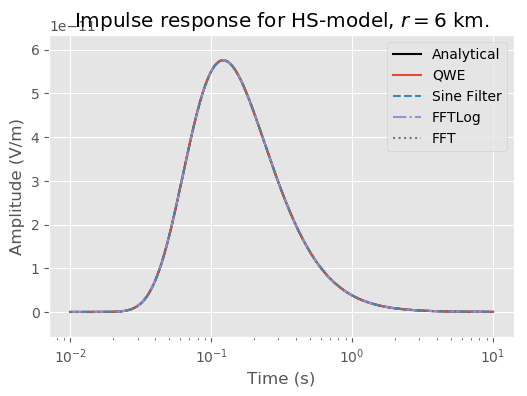

In [6]:
plt.figure()
plt.title(r'Impulse response for HS-model, $r=$' + str(int(rec[0]/1000)) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel(r'Amplitude (V/m)')
plt.semilogx(t, ex, 'k-', label='Analytical')
plt.semilogx(t, qwe, 'C0-', label='QWE')
plt.semilogx(t, sin, 'C1--', label='Sine Filter')
plt.semilogx(t, ftl, 'C2-.', label='FFTLog')
plt.semilogx(t, fft, 'C3:', label='FFT')
plt.legend(loc='best')
plt.ylim([-.1*np.max(ex), 1.1*np.max(ex)])
plt.show()

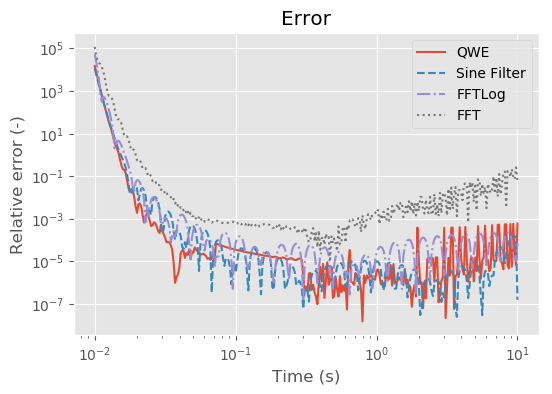

In [7]:
plt.figure()
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative error (-)')
plt.loglog(t, abs(qwe-ex)/ex, 'C0-', label='QWE')
plt.plot(t, abs(sin-ex)/ex, 'C1--', label='Sine Filter')
plt.plot(t, abs(ftl-ex)/ex, 'C2-.', label='FFTLog')
plt.plot(t, abs(fft-ex)/ex, 'C3:', label='FFT')
plt.legend(loc='best')
plt.show()

=> The error is comparable in all cases. `FFT` is not too good at later times. This could be improved by calculating lower frequencies. But because FFT needs regularly spaced data, our vector would soon explode (and you would need a lot of memory). In the current case we are already using 2^20 samples!

### Step response

Step responses are almost impossible with `FFT`. We can either try to model late times with lots of low frequencies, or the step with lots of high frequencies. I do not use `FFT` in the step-response examples.

#### Switch-on

In [8]:
ex = ee_xx_step(res[1], aniso[1], rec[0], t)

inparg['signal'] = 1 # signal 1 = switch-on
print('QWE')
qwe = epm.dipole(**inparg, ft='qwe')
print('FHT (Sine)')
sin = epm.dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
ftl = epm.dipole(**inparg, ft='fftlog', ftarg=['', '', -0.6])

QWE
* WARNING :: Fourier-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 0:00:18.056548 :: 1 kernel call(s)

FHT (Sine)

:: empymod END; runtime = 0:00:00.014824 :: 1 kernel call(s)

FFTLog

:: empymod END; runtime = 0:00:00.009573 :: 1 kernel call(s)



Used number of frequencies:

    - QWE: 159 (0.000794328 - 63095.7 Hz)
    - Sine: 116 (5.33905E-06 - 52028 Hz)
    - FFTLog: 60 (0.000178575 - 141.847 Hz)

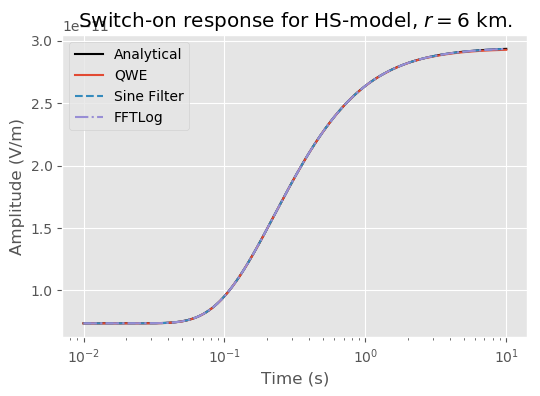

In [9]:
plt.figure()
plt.title(r'Switch-on response for HS-model, $r=$' + str(int(rec[0]/1000)) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V/m)')
plt.semilogx(t, ex, 'k-', label='Analytical')
plt.semilogx(t, qwe, 'C0-', label='QWE')
plt.semilogx(t, sin, 'C1--', label='Sine Filter')
plt.semilogx(t, ftl, 'C2-.', label='FFTLog')
#plt.ylim([0, 4e-11])
plt.legend(loc='best')
plt.show()

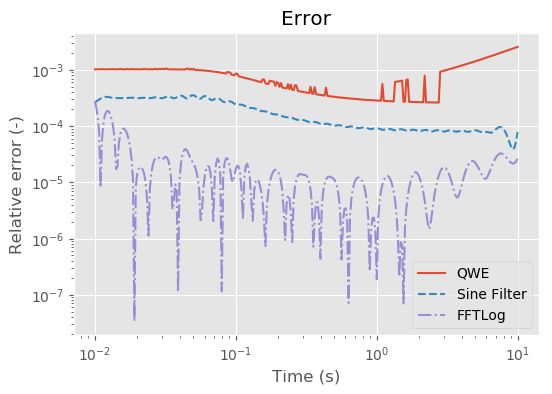

In [10]:
plt.figure()
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative error (-)')
plt.loglog(t, abs(qwe-ex)/ex, 'C0-', label='QWE')
plt.plot(t, abs(sin-ex)/ex, 'C1--', label='Sine Filter')
plt.plot(t, abs(ftl-ex)/ex, 'C2-.', label='FFTLog')
plt.legend(loc='best')
plt.show()

#### Switch-off

For switch-off to work properly you need `empymod`-version bigger than 1.3.0! You can do it with previous releases too, but you will have to do the DC-calculation and subtraction manually, as is done here for `ee_xx_step`.

In [11]:
exDC = ee_xx_step(res[1], aniso[1], rec[0], 60*60)
ex = exDC - ee_xx_step(res[1], aniso[1], rec[0], t)

inparg['signal'] = -1 # signal -1 = switch-off
print('QWE')
qwe = epm.dipole(**inparg, ft='qwe')
print('FHT (Cosine/Sine)')
sin = epm.dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
ftl = epm.dipole(**inparg, ft='fftlog', ftarg=['', [-5, 3]])

QWE
* WARNING :: Fourier-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 0:00:13.139389 :: 1 kernel call(s)

FHT (Cosine/Sine)

:: empymod END; runtime = 0:00:00.014548 :: 1 kernel call(s)

FFTLog

:: empymod END; runtime = 0:00:00.014032 :: 1 kernel call(s)



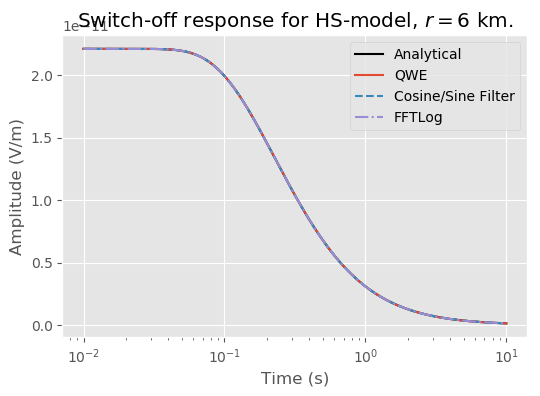

In [12]:
plt.figure()
plt.title(r'Switch-off response for HS-model, $r=$' + str(int(rec[0]/1000)) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V/m)')
plt.semilogx(t, ex, 'k-', label='Analytical')
plt.semilogx(t, qwe, 'C0-', label='QWE')
plt.semilogx(t, sin, 'C1--', label='Cosine/Sine Filter')
plt.semilogx(t, ftl, 'C2-.', label='FFTLog')
#plt.ylim([0, 4e-11])
plt.legend(loc='best')
plt.show()

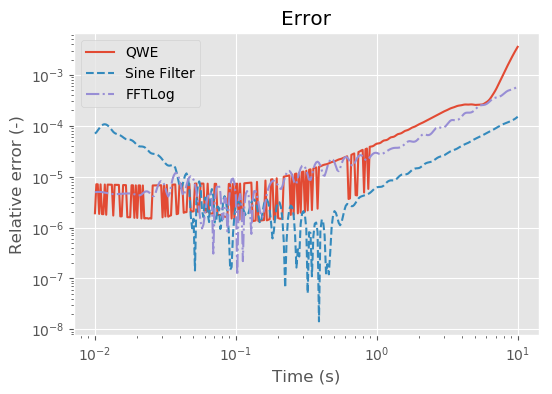

In [13]:
plt.figure()
plt.title('Error')
plt.xlabel('Time (s)')
plt.ylabel('Relative error (-)')
plt.loglog(t, abs(qwe-ex)/ex, 'C0-', label='QWE')
plt.plot(t, abs(sin-ex)/ex, 'C1--', label='Sine Filter')
plt.plot(t, abs(ftl-ex)/ex, 'C2-.', label='FFTLog')
plt.legend(loc='best')
plt.show()

## Example 2: Air-seawater-halfspace

In seawater the transformation is generally much easier, as we do not have the step or the impules at zero time.

In [14]:
src = [0, 0, 950]            # Source 50 m above seabottom
rec = [6000, 0, 1000]        # Receivers in-line, at seabottom
res = [1e23, 1/3, 10]        # Resistivity: [air, water, half-space]
aniso = [1, 1, 2]            # Anisotropy: [air, water, half-space]
t = np.logspace(-2, 1, 301)  # Desired times (s)

# Collect parameters
inparg = {'src': src, 'rec': rec, 'depth': [0, 1000], 'freqtime': t, 'res': res, 'aniso': aniso, 'ht': 'fht', 'verb': 2}

### Impulse response

In [15]:
inparg['signal'] = 0 # signal 0 = impulse
print('QWE')
qwe = epm.dipole(**inparg, ft='qwe', ftarg=['', '', '', 500])
print('FHT (Sine)')
sin = epm.dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
ftl = epm.dipole(**inparg, ft='fftlog')
print('FFT')
fft = epm.dipole(**inparg, ft='fft', ftarg=[.001, 2**15, 2**16, 10])

QWE

:: empymod END; runtime = 0:00:18.154976 :: 1 kernel call(s)

FHT (Sine)

:: empymod END; runtime = 0:00:00.044954 :: 1 kernel call(s)

FFTLog

:: empymod END; runtime = 0:00:00.023013 :: 1 kernel call(s)

FFT

:: empymod END; runtime = 0:00:00.073364 :: 1 kernel call(s)



Used number of frequencies:

    - QWE: 167 (0.000794328 - 158489 Hz)
    - Sine: 116 (5.33905E-06 - 52028 Hz)
    - FFTLog: 60 (0.000178575 - 141.847 Hz)
    - FFT: 46 (0.001 - 32.768 Hz)

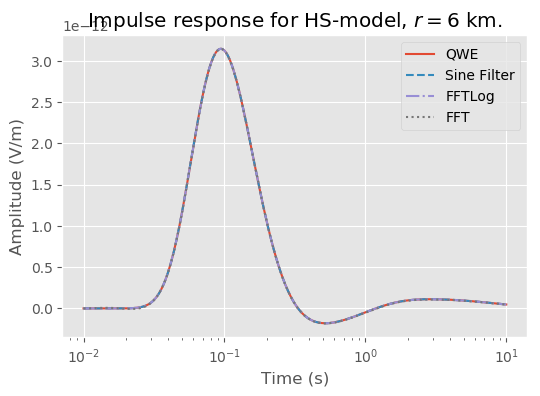

In [16]:
plt.figure()
plt.title(r'Impulse response for HS-model, $r=$' + str(int(rec[0]/1000)) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel(r'Amplitude (V/m)')
plt.semilogx(t, qwe, 'C0-', label='QWE')
plt.semilogx(t, sin, 'C1--', label='Sine Filter')
plt.semilogx(t, ftl, 'C2-.', label='FFTLog')
plt.semilogx(t, fft, 'C3:', label='FFT')
plt.legend(loc='best')
plt.show()

### Step response

In [17]:
inparg['signal'] = 1 # signal 1 = step
print('QWE')
qwe = epm.dipole(**inparg, ft='qwe', ftarg=['', '', 31, 500])
print('FHT (Sine)')
sin = epm.dipole(**inparg, ft='sin', ftarg='key_81_CosSin_2009')
print('FFTLog')
ftl = epm.dipole(**inparg, ft='fftlog', ftarg=['', [-2, 4]])

QWE
* WARNING :: Fourier-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 0:00:15.866888 :: 1 kernel call(s)

FHT (Sine)

:: empymod END; runtime = 0:00:00.041179 :: 1 kernel call(s)

FFTLog

:: empymod END; runtime = 0:00:00.033431 :: 1 kernel call(s)



Used number of frequencies:

    - QWE: 173 (0.000398107 - 158489 Hz)
    - Sine: 116 (5.33905E-06 - 52028 Hz)
    - FFTLog: 90 (0.000178575 - 141847 Hz)

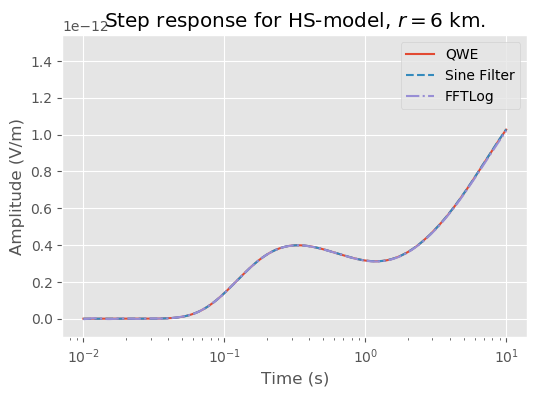

In [18]:
plt.figure()
plt.title(r'Step response for HS-model, $r=$' + str(int(rec[0]/1000)) + ' km.')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V/m)')
plt.semilogx(t, qwe, 'C0-', label='QWE')
plt.semilogx(t, sin, 'C1--', label='Sine Filter')
plt.semilogx(t, ftl, 'C2-.', label='FFTLog')
plt.ylim([-.1e-12, 1.5*qwe.max()])
plt.legend(loc='best')
plt.show()

In [19]:
epm.versions('HTML')